In [ ]:
# %pip install openai>1.50.0 langchain>0.3.0 langgraph langchainhub langchain-openai langchain-community langchain-cli langchain_ollama tavily-python>=0.5.0 langchain_nomic nomic[local] langserve faiss-cpu tiktoken pypdf chroma jira google-search-results numexpr beautifulsoup4 scikit-learn

# Research Agent with LangGraph and Ollama


## This notebook implements a research agent that:
 1. Generates search queries
 2. Performs web research
 3. Summarizes findings
 4. Reflects on results to identify knowledge gaps
# We'll use LangGraph for the agent's workflow and Ollama for local LLM inference.


# 1. Setup and Imports

In [1]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = "your-api-key"
# os.environ["TAVILY_API_KEY"] = "your-api-key"
# os.environ["OPENAI_API_KEY"] = 'your-api-key'
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [2]:
import os
import json
from typing import Optional, Any, List
from typing_extensions import Literal, Annotated

from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langchain_ollama import ChatOllama
from langgraph.graph import START, END, StateGraph

# 2. Configuration Model
First, let's define our configuration using Pydantic instead of dataclasses

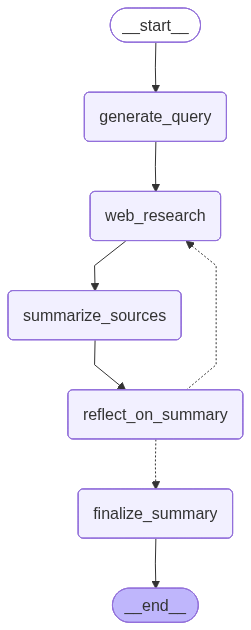

In [3]:
from IPython.display import Image

class Configuration(BaseModel):
    """The configurable fields for the research assistant."""
    max_web_research_loops: int = 3
    local_llm: str = "deepseek-r1"

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            field: os.environ.get(field.upper(), configurable.get(field))
            for field in cls.model_fields.keys()
        }
        return cls(**{k: v for k, v in values.items() if v is not None})

# %% [markdown]
# ## 3. State Models
# Now let's define our state models using Pydantic

# %%
class SummaryState(BaseModel):
    """Main state model for the research agent."""
    research_topic: Optional[str] = None
    search_query: Optional[str] = None
    web_research_results: List[str] = Field(default_factory=list)
    sources_gathered: List[str] = Field(default_factory=list)
    research_loop_count: int = 0
    running_summary: Optional[str] = None

    class Config:
        arbitrary_types_allowed = True

class SummaryStateInput(BaseModel):
    """Input state model."""
    research_topic: Optional[str] = None

class SummaryStateOutput(BaseModel):
    """Output state model."""
    running_summary: Optional[str] = None

# %% [markdown]
# ## 4. Utility Functions
# Let's define our helper functions for web search and source formatting

# %%
from langsmith import traceable
from tavily import TavilyClient

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            char_limit = max_tokens_per_source * 4
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()

def format_sources(search_results):
    """Format search results into a bullet-point list of sources."""
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_results['results']
    )

@traceable
def tavily_search(query, include_raw_content=True, max_results=3):
    """Search the web using the Tavily API."""
    tavily_client = TavilyClient()
    return tavily_client.search(query, 
                         max_results=max_results, 
                         include_raw_content=include_raw_content)

# %% [markdown]
# ## 5. Agent Prompts
# Define the instruction prompts for our agent's components

# %%
query_writer_instructions = """Your goal is to generate targeted web search query.

The query will gather information related to a specific topic.

Topic:
{research_topic}

Return your query as a JSON object:
{{
    "query": "string",
    "aspect": "string",
    "rationale": "string"
}}
"""

summarizer_instructions = """Your goal is to generate a high-quality summary of the web search results.

When EXTENDING an existing summary:
1. Seamlessly integrate new information without repeating what's already covered
2. Maintain consistency with the existing content's style and depth
3. Only add new, non-redundant information
4. Ensure smooth transitions between existing and new content

When creating a NEW summary:
1. Highlight the most relevant information from each source
2. Provide a concise overview of the key points related to the report topic
3. Emphasize significant findings or insights
4. Ensure a coherent flow of information

CRITICAL REQUIREMENTS:
- Start IMMEDIATELY with the summary content - no introductions or meta-commentary
- Focus ONLY on factual, objective information
- Maintain a consistent technical depth
- Avoid redundancy and repetition
- DO NOT use phrases like "based on the new results" or "according to additional sources"
- DO NOT add a References or Works Cited section
- Begin directly with the summary text
"""

reflection_instructions = """You are an expert research assistant analyzing a summary about {research_topic}.

Your tasks:
1. Identify knowledge gaps or areas that need deeper exploration
2. Generate a follow-up question that would help expand your understanding
3. Focus on technical details, implementation specifics, or emerging trends that weren't fully covered

Ensure the follow-up question is self-contained and includes necessary context for web search.

Return your analysis as a JSON object:
{{ 
    "knowledge_gap": "string",
    "follow_up_query": "string"
}}"""

# %% [markdown]
# ## 6. Agent Nodes
# Define the core functions that make up our agent's workflow

# %%
def generate_query(state: SummaryState, config: RunnableConfig):
    """Generate a query for web search"""
    query_writer_instructions_formatted = query_writer_instructions.format(
        research_topic=state.research_topic
    )
    print("Research topic:")
    print(state.research_topic)

    configurable = Configuration.from_runnable_config(config)
    llm_json_mode = ChatOllama(model=configurable.local_llm, temperature=0, format="json")
    result = llm_json_mode.invoke(
        [SystemMessage(content=query_writer_instructions_formatted),
        HumanMessage(content=f"Given this research topic: {state.research_topic}, generate a query for web search, your output should contain a json with a query key:")]
    )
    print("result")
    print(result)   
    query = json.loads(result.content)
    
    print("Query created in generate_query: ", query)
    
    return {"search_query": query['query']}

def web_research(state: SummaryState):  
    """Gather information from the web"""
    print("Current search query", )
    print(state.search_query)
    print(state.research_topic)
    search_results = tavily_search(state.search_query, include_raw_content=True, max_results=1)
    search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000)
    return {
        "sources_gathered": [format_sources(search_results)], 
        "research_loop_count": state.research_loop_count + 1, 
        "web_research_results": [search_str]
    }

def summarize_sources(state: SummaryState, config: RunnableConfig):
    """Summarize the gathered sources"""
    existing_summary = state.running_summary
    most_recent_web_research = state.web_research_results[-1]

    if existing_summary:
        human_message_content = (
            f"Extend the existing summary: {existing_summary}\n\n"
            f"Include new search results: {most_recent_web_research} "
            f"That addresses the following topic: {state.research_topic}"
        )
    else:
        human_message_content = (
            f"Generate a summary of these search results: {most_recent_web_research} "
            f"That addresses the following topic: {state.research_topic}"
        )

    configurable = Configuration.from_runnable_config(config)
    llm = ChatOllama(model=configurable.local_llm, temperature=0)
    result = llm.invoke(
        [SystemMessage(content=summarizer_instructions),
        HumanMessage(content=human_message_content)]
    )

    running_summary = result.content
    return {"running_summary": running_summary}

def reflect_on_summary(state: SummaryState, config: RunnableConfig):
    """Reflect on the summary and generate a follow-up query"""
    configurable = Configuration.from_runnable_config(config)
    llm_json_mode = ChatOllama(model=configurable.local_llm, temperature=0, format="json")
    result = llm_json_mode.invoke(
        [SystemMessage(content=reflection_instructions.format(research_topic=state.research_topic)),
        HumanMessage(content=f"Identify a knowledge gap and generate a follow-up web search query based on our existing knowledge: {state.running_summary}")]
    )   
    follow_up_query = json.loads(result.content)
    query = follow_up_query.get('follow_up_query')
    
    if not query:
        return {"search_query": f"Tell me more about {state.research_topic}"}
    
    return {"search_query": follow_up_query['follow_up_query']}

def finalize_summary(state: SummaryState):
    """Finalize the summary"""
    all_sources = "\n".join(source for source in state.sources_gathered)
    final_summary = f"## Summary\n\n{state.running_summary}\n\n### Sources:\n{all_sources}"
    return {"running_summary": final_summary}

def route_research(state: SummaryState, config: RunnableConfig) -> Literal["finalize_summary", "web_research"]:
    """Route the research based on the follow-up query"""
    configurable = Configuration.from_runnable_config(config)
    if state.research_loop_count <= configurable.max_web_research_loops:
        return "web_research"
    else:
        return "finalize_summary"

# %% [markdown]
# ## 7. Build and Run the Agent
# Now let's put it all together and create our research agent

# %%
# Create the graph
builder = StateGraph(SummaryState, 
                    input=SummaryStateInput, 
                    output=SummaryStateOutput, 
                    config_schema=Configuration)

# Add nodes
builder.add_node("generate_query", generate_query)
builder.add_node("web_research", web_research)
builder.add_node("summarize_sources", summarize_sources)
builder.add_node("reflect_on_summary", reflect_on_summary)
builder.add_node("finalize_summary", finalize_summary)

# Add edges
builder.add_edge(START, "generate_query")
builder.add_edge("generate_query", "web_research")
builder.add_edge("web_research", "summarize_sources")
builder.add_edge("summarize_sources", "reflect_on_summary")
builder.add_conditional_edges("reflect_on_summary", route_research)
builder.add_edge("finalize_summary", END)

# Compile the graph
graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

In [4]:
# %% [markdown]
# ## 8. Example Usage
# Here's how to use the research agent

# %%
# Example research topic
## SS - research topic!!!
research_topic = "How to use LLMs for personal productivity"

# Run the research agent
config = {"configurable": {"max_web_research_loops": 3, "local_llm": "gemma3n"}}
result = graph.invoke(
    {"research_topic": research_topic},
    config=config
)

Research topic:
How to use LLMs for personal productivity
result
content='{\n  "query": "LLM personal productivity use cases",\n  "aspect": "practical applications",\n  "rationale": "This query focuses on real-world examples and specific ways to leverage LLMs (Large Language Models) for improving personal productivity. The phrase \'use cases\' directly targets practical applications and actionable strategies. It\'s a concise and effective way to find tutorials, guides, and examples of how people are currently using LLMs for tasks like writing, planning, organization, and information retrieval."\n}' additional_kwargs={} response_metadata={'model': 'gemma3n', 'created_at': '2025-10-07T16:24:45.048473Z', 'done': True, 'done_reason': 'stop', 'total_duration': 8151706125, 'load_duration': 3189455750, 'prompt_eval_count': 126, 'prompt_eval_duration': 406527458, 'eval_count': 109, 'eval_duration': 4377621500, 'model_name': 'gemma3n'} id='run-5814267f-2e00-44ad-99de-9ada0a7c205b-0' usage_metad

In [5]:
from IPython.display import Markdown
    
Markdown(result["running_summary"])

## Summary

Large Language Models (LLMs) are transforming various applications, with open-source options gaining prominence. Several platforms and communities are focused on developing and supporting open-source LLMs. Notable models include those available through projects like Llama 2, Mistral AI, and Falcon, often utilized for tasks such as text generation, code completion, and question answering. These models are frequently deployed on infrastructure that includes data infrastructure, vector databases, and cloud or on-premise hosting solutions. Tools and techniques, such as prompt engineering, are being developed to mitigate issues like hallucinations and improve the reliability of LLM outputs. The integration of LLMs into existing systems is facilitated by platforms that offer unified interfaces and specialized services for tasks like video meeting summarization, audio content analysis, and action item extraction. Open-source LLM ecosystems are supported by communities offering resources, training, and professional services to aid in their adoption and implementation.

A report details techniques for efficient LLM deployment, specifically quantization, pruning, and distillation. These methods aim to reduce model size and computational requirements, making LLMs more suitable for resource-constrained environments and improving inference speed. Quantization reduces the precision of model weights, pruning removes less important connections, and distillation transfers knowledge from a larger model to a smaller one. These techniques can significantly enhance the practicality of LLMs for personal productivity applications.





### Sources:
* (PDF) Techniques for efficient LLM deployment : https://www.researchgate.net/publication/395380961_Techniques_for_efficient_LLM_deployment_quantization_pruning_distillation/download